# Walmart: Sales Forecast 

## Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

from sklearn import metrics, ensemble, linear_model

import xgboost as xgb

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
INPUT_DIR = '/kaggle/input/walmart-recruiting-store-sales-forecasting'
FEATURES_PATH = './features.csv'
STORES_PATH = './stores.csv'
TEST_PATH = './test.csv'
TRAIN_PATH = './train.csv'
SAMPLE_SUBMISSION_PATH = './sampleSubmission.csv'
RANDOM_STATE = 7

In [3]:
!unzip "$INPUT_DIR/*.csv.zip"
!cp "$INPUT_DIR/stores.csv" "/kaggle/working/"
!ls

Archive:  /kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
  inflating: train.csv               

Archive:  /kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    

Archive:  /kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
  inflating: features.csv            

Archive:  /kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip
  inflating: test.csv                

4 archives were successfully processed.
__notebook__.ipynb  sampleSubmission.csv  test.csv
features.csv	    stores.csv		  train.csv


## Inspect and Cleanup

In [4]:
# Load datasets
features_raw = pd.read_csv(FEATURES_PATH)
stores_raw = pd.read_csv(STORES_PATH)
train_raw = pd.read_csv(TRAIN_PATH)
test_raw = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)

### Check if there are duplicated rows

In [5]:
print(f'Features duplicates: {features_raw.duplicated().sum()}')
print(f'Stores duplicates: {stores_raw.duplicated().sum()}')
print(f'Train duplicates: {train_raw.duplicated().sum()}')

Features duplicates: 0
Stores duplicates: 0
Train duplicates: 0


In [6]:
print(f'Store types: {stores_raw["Type"].unique()}')

Store types: ['A' 'B' 'C']


### Check if Store IDs match. This is important to see if there are missing store features.

In [7]:
print(f'Match: {sum(train_raw["Store"].unique() == features_raw["Store"].unique()) == 45}')

Match: True


### Join features, stores and train data

In [8]:
all_data = train_raw.merge(stores_raw, how='inner', on='Store')\
    .merge(features_raw, how='inner', on=['Store', 'Date', 'IsHoliday'])\
    .reset_index(drop=True).sort_values(['Store', 'Dept', 'Date'])
test = test_raw.merge(stores_raw, how='inner', on='Store')\
    .merge(features_raw, how='inner', on=['Store', 'Date', 'IsHoliday'])\
    .reset_index(drop=True).sort_values(['Store', 'Dept', 'Date'])

In [9]:
# Convert to datetime
all_data['Date'] = pd.to_datetime(all_data['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# New date features
all_data['Day'] = all_data['Date'].dt.isocalendar().day
all_data['Week'] = all_data['Date'].dt.isocalendar().week
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

test['Day'] = test['Date'].dt.isocalendar().day
test['Week'] = test['Date'].dt.isocalendar().week
test['Month'] = test['Date'].dt.month
test['Year'] = test['Date'].dt.year

In [10]:
# Show NA quantities
all_data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Day                  0
Week                 0
Month                0
Year                 0
dtype: int64

In [11]:
all_data.fillna(0, inplace=True)

In [12]:
all_data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Day,Week,Month,Year
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,5,5,2,2010
73,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,5,6,2,2010
145,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,5,7,2,2010
218,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,5,8,2,2010
290,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,5,9,3,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421302,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,5,39,9,2012
421370,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,5,40,10,2012
421436,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,5,41,10,2012
421502,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,5,42,10,2012


### Descriptive statistics over dataset

In [13]:
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Size,421570.0,136727.915739,60980.583328,34875.000,93638.000000,140167.00000,202505.000000,219622.000000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
MarkDown1,421570.0,2590.074819,6052.385934,0.000,0.000000,0.00000,2809.050000,88646.760000
MarkDown2,421570.0,879.974298,5084.538801,-265.760,0.000000,0.00000,2.200000,104519.540000
MarkDown3,421570.0,468.087665,5528.873453,-29.100,0.000000,0.00000,4.540000,141630.610000
MarkDown4,421570.0,1083.132268,3894.529945,0.000,0.000000,0.00000,425.290000,67474.850000


#### Weekly Sales has negative values and very large max value, it seems to be outliers or anomalies.
#### Also Markdown 2 and 3 have negative values.

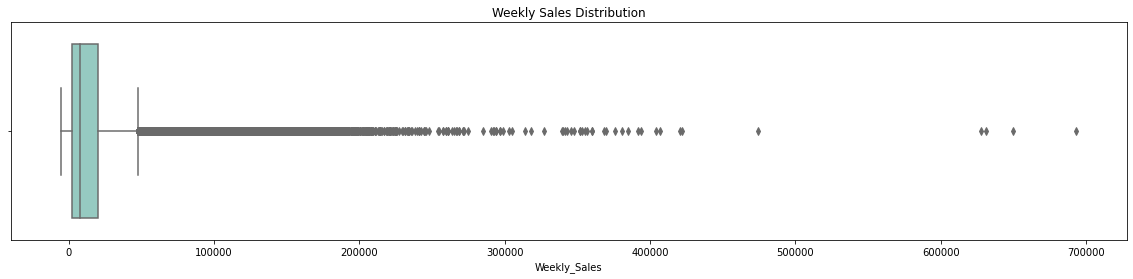

In [14]:
plt.figure(figsize=(20,4))
plt.title('Weekly Sales Distribution')
sns.boxplot(data=all_data, x='Weekly_Sales', palette='Set3')
plt.show()

#### This box plot shows many outliers. But in the folowing line plot, we see that the outliers occurs principaly in the weeks with holidays, every year, like the weeks of Thanksgiving and Christmas.

#### Negative sales will be removed

In [15]:
print(f'Total before remove negative weekly sales: {all_data.shape}')

Total before remove negative weekly sales: (421570, 20)


In [16]:
all_data = all_data[all_data['Weekly_Sales'] >= 0]
all_data.reset_index(inplace=True, drop=True)

In [17]:
print(f'Total after remove negative weekly sales: {all_data.shape}')

Total after remove negative weekly sales: (420285, 20)


#### Negative markdowns turns to zero

In [18]:
all_data.loc[all_data['MarkDown2'] < 0, 'MarkDown2'] = 0
all_data.loc[all_data['MarkDown3'] < 0, 'MarkDown3'] = 0

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [19]:
all_data[all_data['IsHoliday'] == True]['Week'].unique()

<IntegerArray>
[6, 36, 47, 52]
Length: 4, dtype: UInt32

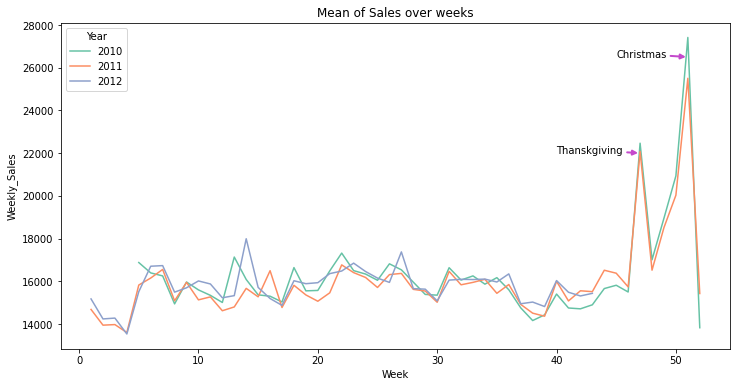

In [20]:
arrowprops = dict(arrowstyle='-|>', color='#c449cc', linewidth=2)

plt.figure(figsize=(12,6))
plt.title('Mean of Sales over weeks')
# Mean of sales grouped by weeks
line1 = sns.lineplot(data=all_data, x='Week', y='Weekly_Sales', hue='Year', estimator='mean', ci=None, palette='Set2')
line1.annotate(text="Thanskgiving", xy=(47,22000), xytext=(40,22000), arrowprops=arrowprops)
line1.annotate(text="Christmas", xy=(51,26500), xytext=(45,26500), arrowprops=arrowprops)
plt.show()

## Features Relations

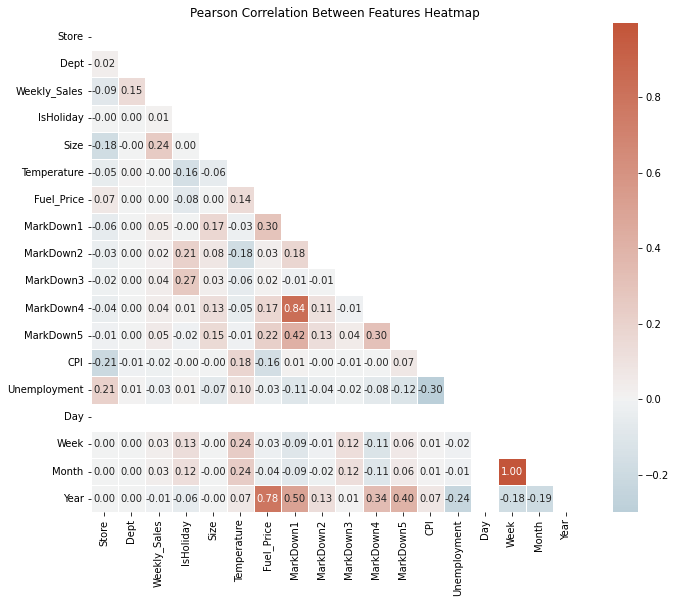

In [21]:
all_data_corr = all_data.corr(method='pearson')
mask = np.triu(np.ones_like(all_data_corr, dtype=bool))

plt.subplots(figsize=(12, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.title('Pearson Correlation Between Features Heatmap')
sns.heatmap(all_data_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=True, fmt='.2f')
plt.show()

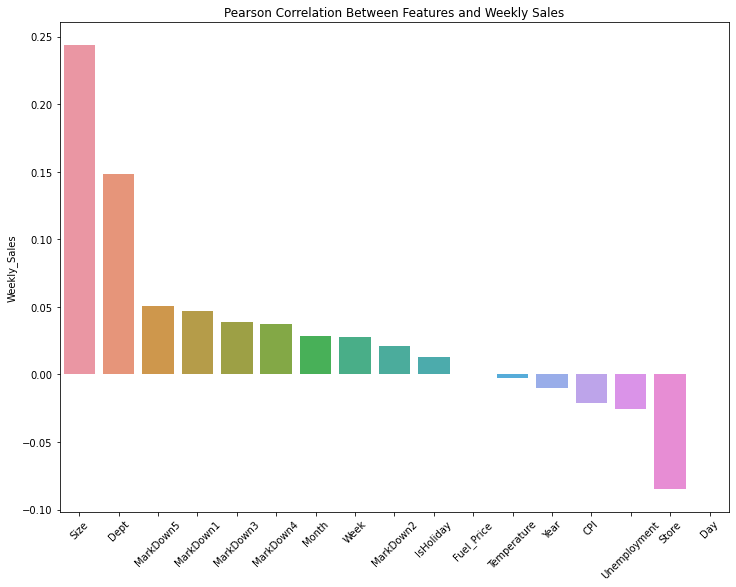

In [22]:
plt.subplots(figsize=(12, 9))
plt.title('Pearson Correlation Between Features and Weekly Sales')
weekly_corr = pd.DataFrame(data=all_data_corr.iloc[2,:], index=all_data_corr.iloc[2,:].index ).sort_values('Weekly_Sales', ascending=False)
sns.barplot(data=weekly_corr.iloc[1:], x=weekly_corr.iloc[1:].index, y='Weekly_Sales')
plt.xticks(rotation=45)
plt.show()

#### All correlations are low, but there is something interesting in the positive correlation with store size - People seems to buy more in bigger stores.

#### As we don't have relevant linear relationship, I will verify the Mutual Information (MI) metric, because it can verify any kind of relationship (not only linear like correlation). 

In [23]:
def make_mi_scores(X, y):
    X = X.copy()

    for colname in X.select_dtypes(['object', 'category', 'datetime64[ns]']):
        if X[colname].dtype == 'datetime64[ns]':
            X[colname], _ = X[colname].dt.strftime('%Y-%m-%d').factorize()
        else:
            X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)

    sns.barplot(y=width, x=scores, orient='h')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

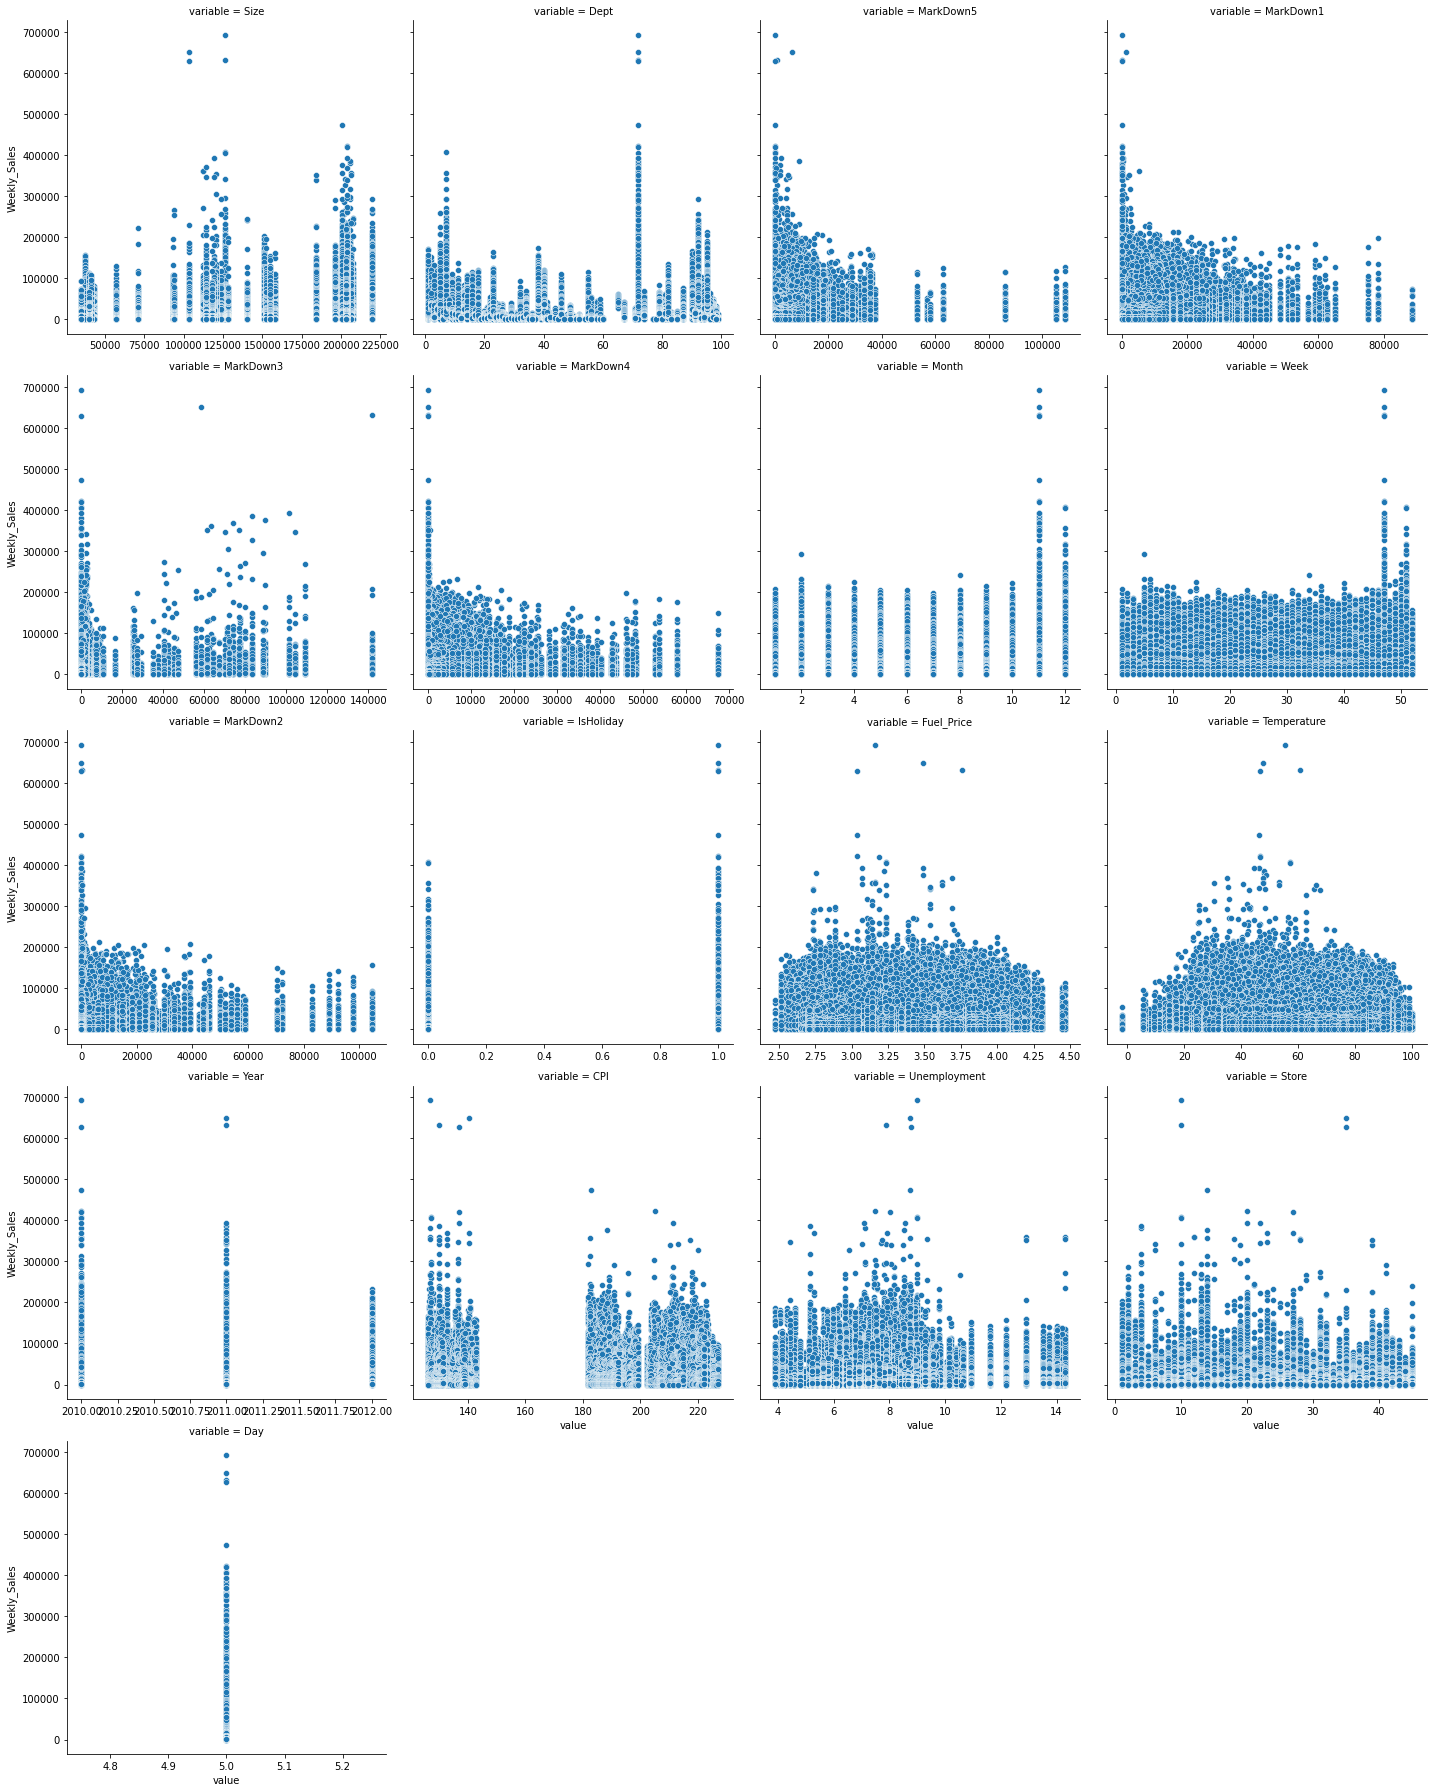

In [24]:
mi_features = weekly_corr[1:].index
sns.relplot(
    x="value", y="Weekly_Sales", col="variable",
    data=all_data.melt(id_vars="Weekly_Sales", value_vars=mi_features),
    col_wrap=4,
    facet_kws=dict(sharex=False),
);

#### Some insigths:

- Fuel price not affect Weekly Sales;
- People buy more when temperature is between 20ºF and 80ºF: Irrelevant;
- CPI not affects the sales in a relevante way, with high CPI people continue buying;
- With low unemploymnent rate, higher are the sales.

In [25]:
mi_X = all_data.drop('Weekly_Sales', axis=1).copy()
mi_y = all_data['Weekly_Sales'].copy()

mi_scores = make_mi_scores(mi_X, mi_y)

Dept            0.851006
Store           0.168071
Size            0.155128
Unemployment    0.093118
Type            0.065350
CPI             0.028438
MarkDown1       0.021326
Temperature     0.020143
MarkDown5       0.019034
Fuel_Price      0.013681
Year            0.011335
MarkDown3       0.010741
MarkDown4       0.009793
Date            0.008470
Month           0.006674
Week            0.005605
MarkDown2       0.005554
IsHoliday       0.000761
Day             0.000000
Name: MI Scores, dtype: float64


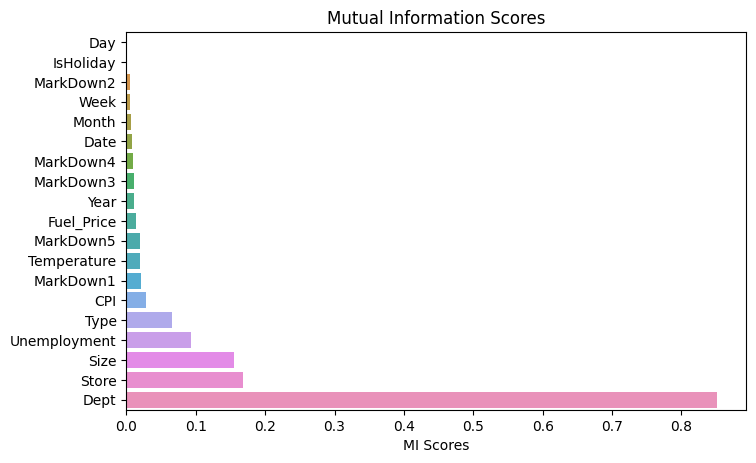

In [26]:
print(mi_scores)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

#### One more time, we see low relationship between features and targets. This means that the features, individualy, cannot explain with higher confidence the increase or decrease of weekly sales.

## Feature Enginering

In [27]:
train_data = all_data.copy()

In [28]:
test.isna().sum()[test.isna().sum() > 0]

MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
CPI             38162
Unemployment    38162
dtype: int64

<AxesSubplot:title={'center':'CPI Distribution'}, ylabel='CPI'>

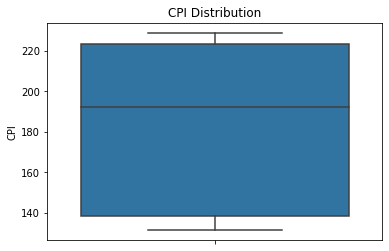

In [29]:
plt.title('CPI Distribution')
sns.boxplot(y=test['CPI'])

<AxesSubplot:title={'center':'Unemployment Distribution'}, ylabel='Unemployment'>

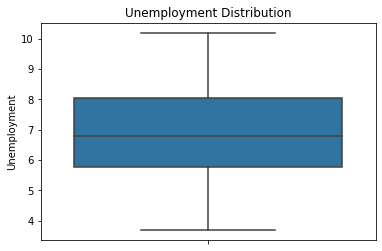

In [30]:
plt.title('Unemployment Distribution')
sns.boxplot(y=test['Unemployment'])

#### How the bloxplots displayed, the median line is more centralized, so they seems to be a symetrical distribution. For symetrical distributions the mean explain more the distribution tendency than the median, so I will fill NA values with the mean.

In [31]:
test['CPI'].fillna(test['CPI'].mean(), inplace=True)
test['Unemployment'].fillna(test['Unemployment'].mean(), inplace=True)

In [32]:
test.fillna(0, inplace=True)

In [33]:
test.isna().sum()

Store           0
Dept            0
Date            0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Day             0
Week            0
Month           0
Year            0
dtype: int64

### Encode some categorical features

In [34]:
store_types = dict((v, k) for k, v in enumerate(stores_raw['Type'].unique(), 1))

In [35]:
print(f'Store types: {store_types}')

Store types: {'A': 1, 'B': 2, 'C': 3}


In [36]:
train_data['IsHoliday'] = train_data['IsHoliday'].apply(lambda x: 1 if x else 0)
train_data['Type'] = train_data['Type'].apply(lambda x: store_types[x])

test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x else 0)
test['Type'] = test['Type'].apply(lambda x: store_types[x])

## Prepare data

In [37]:
X = train_data.drop(['Date', 'Weekly_Sales'], axis=1).copy()
y = train_data['Weekly_Sales'].copy()

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.1)

## Baseline model

#### Competition Metric: $\textrm{WMAE} = \frac{1}{\sum{w_i}} \sum_{i=1}^n w_i | y_i - \hat{y}_i |$

In [39]:
def weighted_mae(dataset, expected, predicted):
    weights = dataset['IsHoliday'].apply(lambda x: 5 if x else 1)
    
    return np.round(np.sum(weights * abs(expected - predicted)) * (1/np.sum(weights)), 2)

#### Check if the features that before showed weak correlation, realy has low influency in a model prediction if they were shuffled. I will check that using Permutation Importance.

In [40]:
xgb_r = xgb.XGBRegressor(random_state=RANDOM_STATE, objective='reg:squarederror')

In [41]:
xgb_r.fit(X_train.values, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=7, reg_alpha=0,
             reg_lambda=1, ...)

In [42]:
permutations = PermutationImportance(xgb_r, random_state=RANDOM_STATE).fit(X_valid, y_valid)
features_pi = eli5.show_weights(permutations, top=len(X_train.columns), feature_names = X_valid.columns.tolist())

In [43]:
features_weights = eli5.show_weights(permutations, top=len(X_train.columns), feature_names = X_valid.columns.tolist())

In [44]:
pd.read_html(features_weights.data)[0]

,Weight,Feature
0,1.6524 ± 0.0275,Dept
1,0.4626 ± 0.0056,Size
2,0.1157 ± 0.0065,Store
3,0.0760 ± 0.0047,Week
4,0.0386 ± 0.0028,CPI
5,0.0095 ± 0.0007,Type
6,0.0072 ± 0.0003,Unemployment
7,0.0068 ± 0.0025,IsHoliday
8,0.0042 ± 0.0009,Temperature
9,0.0036 ± 0.0038,MarkDown3


#### To understand Permutation Importance, look at the values of weight. For example, for Dept, the first value of weight shows how much the 'accuracy' of the model can decrease if Dept is random shuffled, the second value shows how the first value change from one shuffle to another in the various internals shuffles of the Permutation Importance algorithm.

#### With this observation, and other made before, I will select only relevant features for the final model

In [45]:
relevant_features = ['Dept', 'Size', 'Store', 'Week', 'Type', 'IsHoliday', 'Month', 'Year']

In [46]:
X_train_relevant = X_train[relevant_features]
X_valid_relevant = X_valid[relevant_features]

## Compare some models

In [47]:
base_models = {
    'xgbRegressor': xgb.XGBRegressor(random_state=RANDOM_STATE, objective='reg:squarederror'),
    'randomForest': ensemble.RandomForestRegressor(random_state=RANDOM_STATE),
    'extraTrees': ensemble.ExtraTreesRegressor(bootstrap = True, random_state=RANDOM_STATE),
}

In [48]:
for model_name, model in base_models.items():
    model.fit(X_train_relevant.values, y_train)
    
    predictions = model.predict(X_valid_relevant.values)
    
    print(f'Model: {model_name}: \
          \n - WMAE {weighted_mae(X_valid_relevant, y_valid, predictions)} \
          \n - RMSE {metrics.mean_squared_error(y_valid, predictions, squared=False):.2f}')

Model: xgbRegressor:           
 - WMAE 3164.03           
 - RMSE 5677.64
Model: randomForest:           
 - WMAE 1435.11           
 - RMSE 3199.93
Model: extraTrees:           
 - WMAE 1591.85           
 - RMSE 3900.57


#### Random Forest showed the best result, so I will proceed with it

In [49]:
random_forest = ensemble.RandomForestRegressor(n_estimators=58, max_depth=27, 
                                               min_samples_split=3, min_samples_leaf=1, n_jobs=-1,
                                               random_state=RANDOM_STATE)

In [50]:
random_forest.fit(X_train_relevant.values, y_train)

RandomForestRegressor(max_depth=27, min_samples_split=3, n_estimators=58,
                      n_jobs=-1, random_state=7)

In [51]:
valid_predictions = random_forest.predict(X_valid_relevant.values)

In [52]:
week_valid_preds = pd.DataFrame({'week': X_valid_relevant['Week'], 'predictions': valid_predictions, 'expected': y_valid})

In [53]:
print(f'- WMAE {weighted_mae(X_valid_relevant, y_valid, valid_predictions)}\
      \n- RMSE {metrics.mean_squared_error(y_valid, predictions, squared=False):.2f}')

- WMAE 1447.25      
- RMSE 3900.57


## Test and Submission file generation

In [54]:
X_test = test[relevant_features]

In [55]:
test_predictions = random_forest.predict(X_test.values)

In [56]:
sample_submission['Weekly_Sales'] = test_predictions

In [57]:
sample_submission

,Id,Weekly_Sales
0,1_1_2012-11-02,31524.149503
1,1_1_2012-11-09,19027.507606
2,1_1_2012-11-16,19166.980399
3,1_1_2012-11-23,20336.367198
4,1_1_2012-11-30,21486.152080
...,...,...
115059,45_98_2013-06-28,679.927652
115060,45_98_2013-07-05,689.828845
115061,45_98_2013-07-12,697.089385
115062,45_98_2013-07-19,754.230537


In [58]:
sample_submission.to_csv('submission.csv', index=False)